Simulation: Predictive vs. Non-Predictive Scheduling

In [11]:
pip install simpy


In [12]:
import simpy
import random
import matplotlib.pyplot as plt


Define Parameters

In [13]:
RANDOM_SEED = 42
SIM_TIME = 1000  # in simulation time units
INTER_ARRIVAL_TIME = 10  # mean time between job arrivals
SERVICE_TIME = 8  # average service time for each job


Define ML Pipeline Server

In [14]:
class MLSystem:
    def __init__(self, env, num_servers):
        self.env = env
        self.server = simpy.Resource(env, capacity=num_servers)

    def process_job(self, job_id):
        yield self.env.timeout(random.expovariate(1.0 / SERVICE_TIME))


Job Arrival Logic

In [15]:
def job_generator(env, system, wait_times, predictive=False):
    job_id = 0
    while True:
        inter_arrival = random.expovariate(1.0 / INTER_ARRIVAL_TIME)

        # Predictive scheduling: stagger high loads
        if predictive and job_id % 10 == 0:
            inter_arrival += 5  # simulate load spreading

        yield env.timeout(inter_arrival)
        job_id += 1
        env.process(handle_job(env, system, job_id, wait_times))


Job Handling Logic

In [16]:
def handle_job(env, system, job_id, wait_times):
    arrival = env.now
    with system.server.request() as request:
        yield request
        wait = env.now - arrival
        wait_times.append(wait)
        yield env.process(system.process_job(job_id))


Run Simulation and Compare

In [17]:
def run_simulation(predictive=False):
    env = simpy.Environment()
    system = MLSystem(env, num_servers=2)
    wait_times = []
    env.process(job_generator(env, system, wait_times, predictive))
    env.run(until=SIM_TIME)
    return wait_times

# Run both scenarios
non_predictive_waits = run_simulation(predictive=False)
predictive_waits = run_simulation(predictive=True)


Results

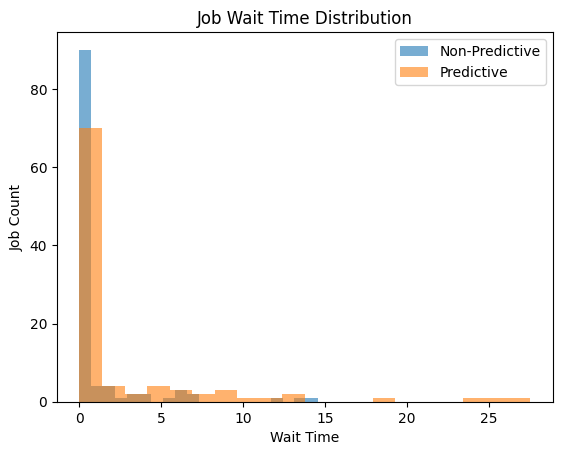

In [18]:
plt.hist(non_predictive_waits, bins=20, alpha=0.6, label='Non-Predictive')
plt.hist(predictive_waits, bins=20, alpha=0.6, label='Predictive')
plt.title("Job Wait Time Distribution")
plt.xlabel("Wait Time")
plt.ylabel("Job Count")
plt.legend()
plt.show()
